<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](03.00-experts-novices.ipynb) | [Contents](Index.ipynb) | [EMG](03.02-emg.ipynb) >

# Joint contribution

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import altair as alt
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Read data

In [3]:
data_path = Path(
    "/media/romain/E/Projet_ExpertsNovices/ElaboratedData/contribution_articulation/SPM/matlab_rob.mat"
)

In [4]:
import scipy.io as spio


def loadmat(filename):
    """
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    """
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    """
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict


def _todict(matobj):
    """
    A recursive function which constructs from matobjects nested dictionaries
    """
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [5]:
mat = loadmat(data_path)["SPM"]
joints = ["deltahand", "deltaGH", "deltaSCAC", "deltaRoB"]
metas = [
    "expertise",
    "weight",
    "height",
    "fatigue",
    "lateralite",
    "duration",
    "subject",
]

data = (
    pd.concat([pd.Series(mat[key]).rename(key) for key in metas], axis=1)
    .join(
        pd.concat(
            [
                pd.DataFrame(mat[key]).assign(
                    joint=key.replace("delta", "")
                    .replace("hand", "WR/EL")
                    .replace("SCAC", "SC/AC")
                    .replace("RoB", "TR/PE")
                )
                for key in joints
            ]
        )
    )
    .query("height == 2 & fatigue == 1")  # relative weight and before fatigue
    .reset_index()
    .set_index(metas + ["joint", "index"])
)


data.sample(5)

0   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -15.294412   
          12     2      1       0          3.8775   2       WR/EL 55     16.843892   
2         12     2      1       1          6.9020   7       WR/EL 295    16.830136   
                                           3.8900   22      WR/EL 1016  -14.162308   
1         8      2      1       1          2.4340   29      GH    1347   -7.566819   

                                                                                1   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -15.918661   
          12     2      1       0          3.8775   2       WR/EL 55     17.855729   
2         12     2      1       1          6.9020   7       WR/EL 295    19.364049   
                                           3.8900   22      WR/EL 1016  -15.276836   
1         8      2      1       1          2.4340   29      GH    1347   -7.549989   

                                                                                2   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -16.901433   
          12     2      1       0          3.8775   2       WR/EL 55     19.549915   
2         12     2      1       1          6.9020   7       WR/EL 295    21.592153   
                                           3.8900   22      WR/EL 1016  -16.073872   
1         8      2      1       1          2.4340   29      GH    1347   -7.463114   

                                                                                3   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -17.475721   
          12     2      1       0          3.8775   2       WR/EL 55     21.094498   
2         12     2      1       1          6.9020   7       WR/EL 295    21.753714   
                                           3.8900   22      WR/EL 1016  -15.105037   
1         8      2      1       1          2.4340   29      GH    1347   -7.362860   

                                                                                4   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -17.591700   
          12     2      1       0          3.8775   2       WR/EL 55     22.426173   
2         12     2      1       1          6.9020   7       WR/EL 295    22.084396   
                                           3.8900   22      WR/EL 1016  -12.801871   
1         8      2      1       1          2.4340   29      GH    1347   -7.333481   

                                                                                5   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -17.484244   
          12     2      1       0          3.8775   2       WR/EL 55     23.540753   
2         12     2      1       1          6.9020   7       WR/EL 295    18.414680   
                                           3.8900   22      WR/EL 1016  -11.645440   
1         8      2      1       1          2.4340   29      GH    1347   -7.435435   

                                                                                6   \
expertise weight height fatigue lateralite duration subject joint index              
1         8      2      1       1          3.0300   25      TR/PE 1153  -17.337421   
          12     2      1       0          3.8775   2       WR/EL 55     24.418901   
2         12     2      1       1          6.9020   7       WR/EL 295    20.488693   
                                

## Stats

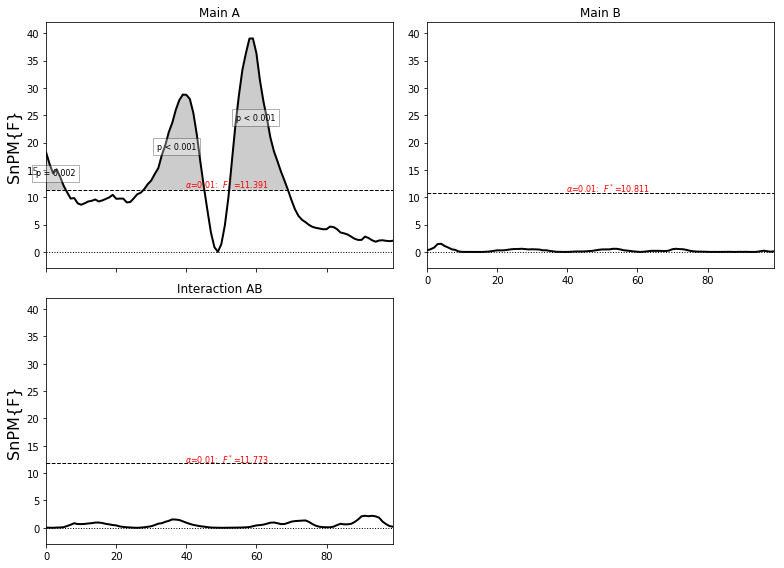

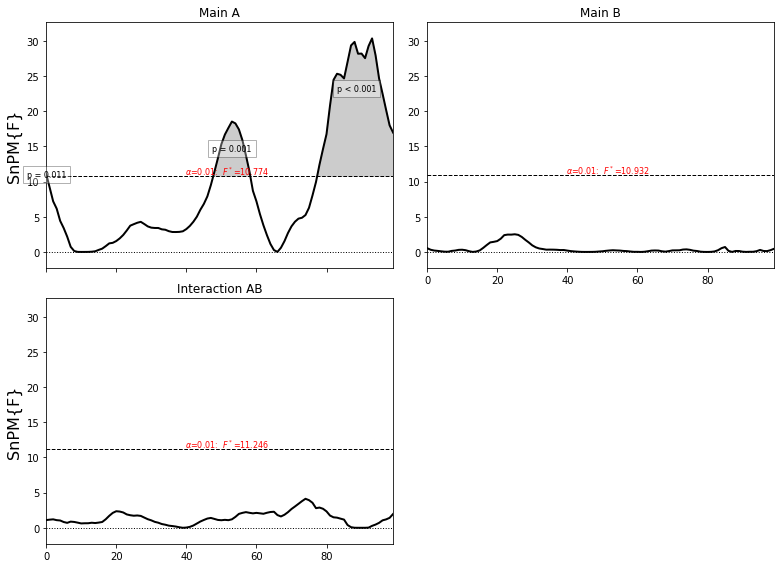

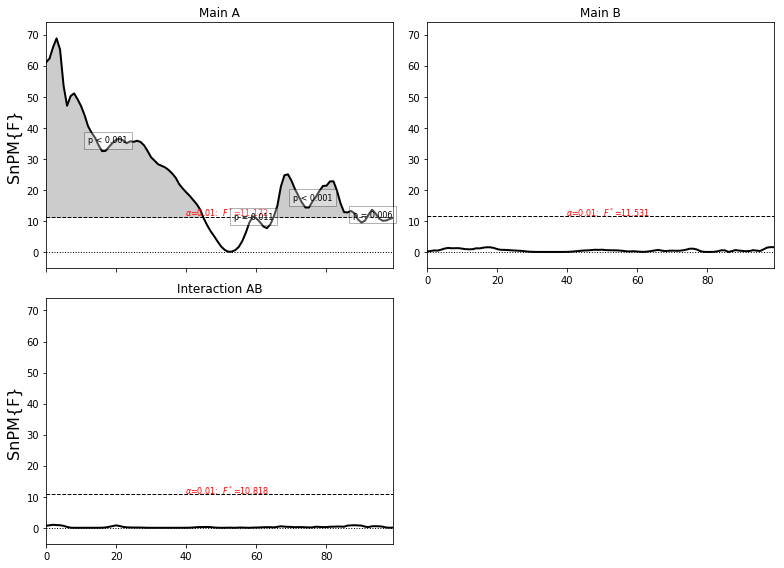

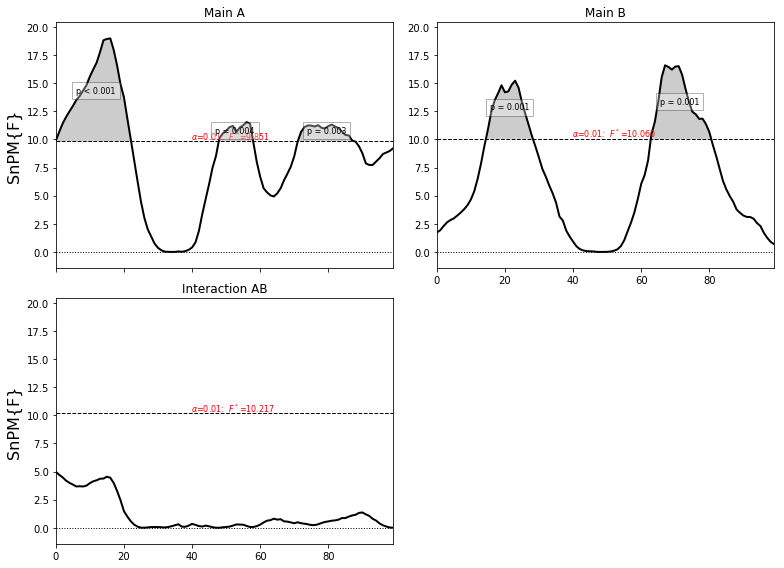

In [6]:
s = {}
α = 0.05 / 4
n_iter = 1000
non_param = True

for ijoint in data.index.unique("joint"):
    y = data.query("joint == @ijoint")

    if non_param:
        spm = spm1d.stats.nonparam.anova2(
            y.to_numpy(),
            A=y.index.get_level_values("expertise"),
            B=y.index.get_level_values("weight"),
        )
        s[ijoint] = spm.inference(alpha=α, iterations=n_iter)
    else:
        spm = spm1d.stats.anova2(
            y.to_numpy(),
            A=y.index.get_level_values("expertise"),
            B=y.index.get_level_values("weight"),
        )
        s[ijoint] = spm.inference(alpha=α)

    plt.figure(figsize=(11, 8))
    s[ijoint].plot()
    plt.tight_layout()

## Plots

In [7]:
clusters = pd.concat(
    [
        get_spm_cluster(
            ispmi,
            labels={
                "Main A": "main expertise",
                "Main B": "main mass",
                "Interaction AB": "interaction expertise-mass",
            },
            mult=1 / y.shape[1],
        ).assign(joint=ijoint)
        for ijoint, ispmi in s.items()
    ]
)
clusters

,effect,p,start,end,joint
0,main expertise,0.00233333,0,0.0558231,WR/EL
1,main expertise,0,0.278321,0.451229,WR/EL
2,main expertise,0,0.522194,0.689709,WR/EL
0,main expertise,0.011,0,0.00177557,GH
1,main expertise,0.00133333,0.476774,0.582498,GH
2,main expertise,0,0.773303,0.99,GH
0,main expertise,0,0,0.448583,SC/AC
1,main expertise,0.011,0.588404,0.594639,SC/AC
2,main expertise,0,0.648804,0.88642,SC/AC
3,main expertise,0.00633333,0.915508,0.947448,SC/AC


In [8]:
def clean_clusters(c):
    last_end = None
    c = c.copy()
    for i, irow in c.iterrows():
        if last_end and irow["start"] - last_end < 0.05:
            c.loc[i, "start"] = last_end
        last_end = t["end"]

    for i, irow in c.iterrows():
        if irow["end"] - irow["start"] < 0.05:
            c.loc[i, "delete"] = 1
    return c.query("delete != 1").drop("delete", axis=1)

In [9]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [10]:
data_melt = (
    data.stack()
    .rename("value")
    .reset_index()
    .rename(columns={"index": "trial", "level_9": "index"})
    .eval("index = index / 100")
    .eval("value = value / 100")
    .eval("expertise = expertise - 1")
    .rename(columns={"expertise": "expert"})
    .drop(["height", "fatigue", "lateralite", "duration", "subject", "trial"], axis=1)
)
data_melt.head()

,expert,weight,joint,index,value
0,0,8,WR/EL,0.00,0.114936
1,0,8,WR/EL,0.01,0.119045
2,0,8,WR/EL,0.02,0.124720
3,0,8,WR/EL,0.03,0.127896
4,0,8,WR/EL,0.04,0.128642


In [11]:
base = alt.Chart(data_melt).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y("mean(value)", title="contribution", axis=alt.Axis(format="%"))
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
expert_scale = alt.Scale(scheme="set1")

joint_domain = ["WR/EL", "GH", "SC/AC", "TR/PE"]
joint_scale = alt.Scale(
    domain=joint_domain, range=["#8da0cb", "#e78ac3", "#fc8d62", "#66c2a5"]
)

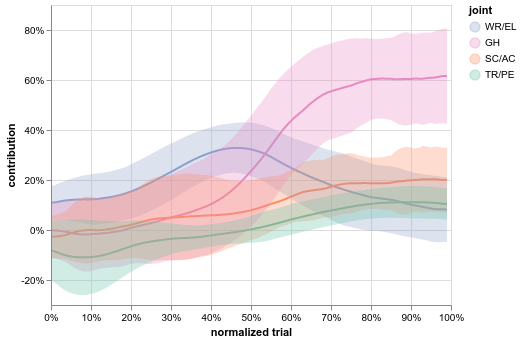

In [12]:
(mu + sigma).encode(alt.Color("joint", scale=joint_scale))

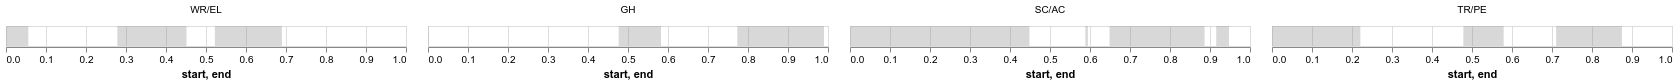

In [13]:
c.transform_filter('datum.effect == "main expertise"').facet(
    column=alt.Column("joint", title=None, sort=joint_domain)
)

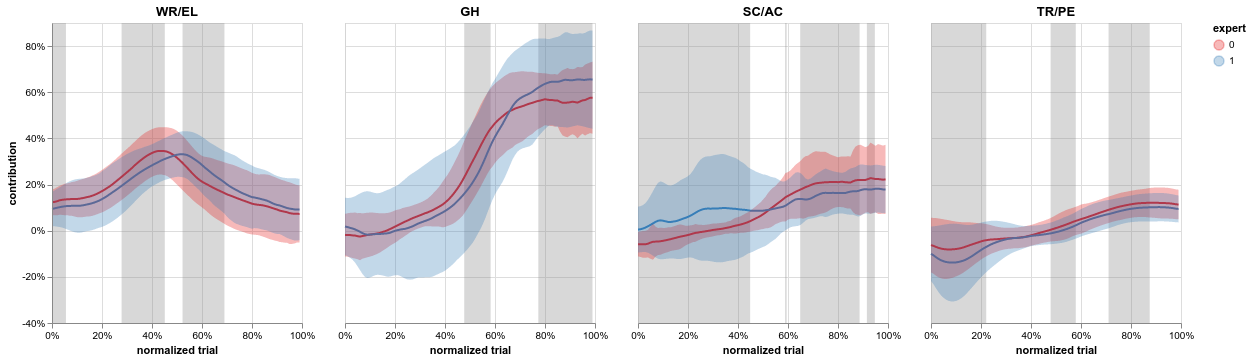

In [17]:
empty_axis = alt.Axis(format="%", labels=False, ticks=False, domain=False)

wrel = c.transform_filter(
    f'datum.effect == "main expertise" & datum.joint == "WR/EL"'
) + (mu + sigma).encode(alt.Color("expert:N", scale=expert_scale)).transform_filter(
    f'datum.joint == "WR/EL"'
)

gh = c.transform_filter(f'datum.effect == "main expertise" & datum.joint == "GH"') + (
    mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma
).encode(alt.Color("expert:N", scale=expert_scale)).transform_filter(
    f'datum.joint == "GH"'
)

scac = c.transform_filter(
    f'datum.effect == "main expertise" & datum.joint == "SC/AC"'
) + (mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma).encode(
    alt.Color("expert:N", scale=expert_scale)
).transform_filter(
    f'datum.joint == "SC/AC"'
)

trpe = c.transform_filter(
    f'datum.effect == "main expertise" & datum.joint == "TR/PE"'
) + (mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma).encode(
    alt.Color("expert:N", scale=expert_scale)
).transform_filter(
    f'datum.joint == "TR/PE"'
)

width = 250

(
    wrel.properties(title="WR/EL", width=width)
    | gh.properties(title="GH", width=width)
    | scac.properties(title="SC/AC", width=width)
    | trpe.properties(title="TR/PE", width=width)
).resolve_scale(y="shared")

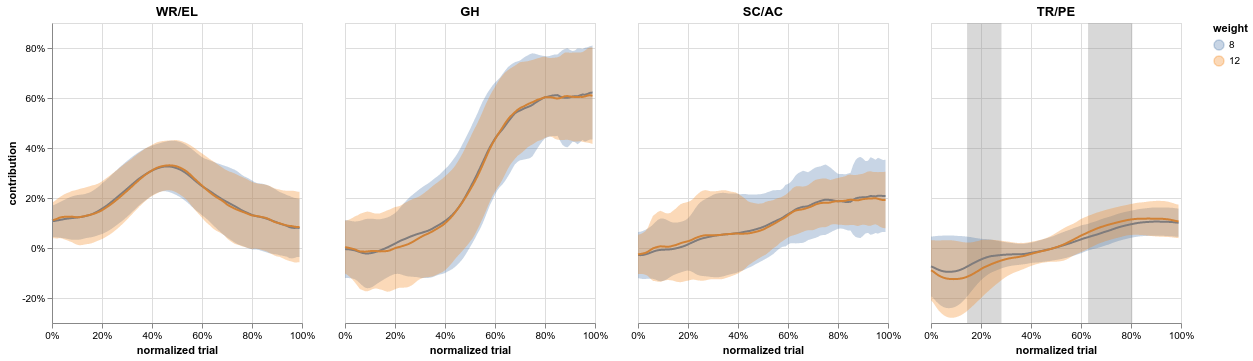

In [18]:
wrel = c.transform_filter(f'datum.effect == "main mass" & datum.joint == "WR/EL"') + (
    mu + sigma
).encode(alt.Color("weight:N")).transform_filter(f'datum.joint == "WR/EL"')

gh = c.transform_filter(f'datum.effect == "main mass" & datum.joint == "GH"') + (
    mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma
).encode(alt.Color("weight:N")).transform_filter(f'datum.joint == "GH"')

scac = c.transform_filter(f'datum.effect == "main mass" & datum.joint == "SC/AC"') + (
    mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma
).encode(alt.Color("weight:N")).transform_filter(f'datum.joint == "SC/AC"')

trpe = c.transform_filter(f'datum.effect == "main mass" & datum.joint == "TR/PE"') + (
    mu.encode(alt.Y("mean(value)", title=None, axis=empty_axis)) + sigma
).encode(alt.Color("weight:N")).transform_filter(f'datum.joint == "TR/PE"')

(
    wrel.properties(title="WR/EL", width=width)
    | gh.properties(title="GH", width=width)
    | scac.properties(title="SC/AC", width=width)
    | trpe.properties(title="TR/PE", width=width)
).resolve_scale(y="shared")

<!--NAVIGATION-->
< [Analyses](03.00-experts-novices.ipynb) | [Contents](Index.ipynb) | [EMG](03.02-emg.ipynb) >